# English Handwritten Text Recognition CRNN Model
<br>
References: 
* https://www-i6.informatik.rwth-aachen.de/publications/download/1014/VoigtlaenderPaulDoetschPatrickNeyHermann--HwritingRecognitionwithLargeMultidimensionalLongShort-TermMemoryRecurrentNeuralNetworks--2016.pdf
* http://people.idsia.ch/~juergen/nips2009.pdf
* https://web.stanford.edu/~jurafsky/slp3/4.pdf

### Import required packages 

In [1]:
import numpy as np
import glob
import os
import time
from xml.etree import ElementTree
import cv2
import matplotlib.pyplot as plt
import pickle
import tempfile
import tensorflow as tf
import warpctc_tensorflow
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
from utils import sparse_tuple_from as sparse_tuple_from
from md_lstm import *
from utils import *
from spell import correction
np.random.seed(1)

ModuleNotFoundError: No module named 'warpctc_tensorflow'

### Import and consolidate data 

In [3]:
def readData(data_folder_path, height_cap, width_cap, lab_length_cap):
    """
    Return consolidated and preprocessed images (list) and labels (list) 
    imported from the provided locations. 
    Character mapping dictionary is also returned to decode labels. 
    
    Arguments:
    data_folder_path  -- Path of folder containing IAM lines folder, lines.txt,
    testset.txt (combined testset and validationset2), trainset.txt, validationset.txt and chars.txt
    """
    
    # Create char_map
    with open(data_folder_path+'/chars.txt', 'rb') as f:
        all_chars = f.read().decode('unicode_escape')
        chars = all_chars.split()
    char_map = {value: idx for (idx, value) in enumerate(chars)}

    # Extract label text and IDs from lines.txt
    with open(data_folder_path+'/lines.txt', 'rb') as f:
        char = f.read().decode('unicode_escape')
        line_raw = char[1025:].splitlines()
    line_data = {line.split()[0] : (int(line.split()[2]), 
                                [char_map[char] for char in line.split()[8]]) for line in line_raw}
    
    # Extract IDs for test, train and val sets
    with open(data_folder_path+'/trainset.txt', 'rb') as f:
        IDs = f.read().decode('unicode_escape')
        trainIDs = IDs.splitlines()
    with open(data_folder_path+'/validationset.txt', 'rb') as f:
        IDs = f.read().decode('unicode_escape')
        valIDs = IDs.splitlines()
    with open(data_folder_path+'/testset.txt', 'rb') as f:
        IDs = f.read().decode('unicode_escape')
        testIDs = IDs.splitlines()
    
    # For random order generation (shuffling)
    train_p = np.random.permutation(len(trainIDs))
    val_p = np.random.permutation(len(valIDs))
    test_p = np.random.permutation(len(testIDs))
    
    # Import images and labels (map label IDs with label_dict)
    train_images, train_labels, train_im_widths, train_lab_lengths = np.zeros(
        shape = (len(trainIDs), height_cap, width_cap), dtype=np.float32), [None]*len(trainIDs), np.zeros(
        shape = (len(trainIDs))), np.zeros(
        shape = (len(trainIDs)))
    val_images, val_labels, val_im_widths, val_lab_lengths = np.zeros(
        shape = (len(valIDs), height_cap, width_cap), dtype=np.float32), [None]*len(valIDs), np.zeros(
        shape = (len(valIDs))), np.zeros(
        shape = (len(valIDs)))
    test_images, test_labels, test_im_widths, test_lab_lengths = np.zeros(
        shape = (len(testIDs), height_cap, width_cap), dtype=np.float32), [None]*len(testIDs), np.zeros(
        shape = (len(testIDs))), np.zeros(
        shape = (len(testIDs)))
    
    im_num, train_im_num, val_im_num, test_im_num = 0, 0, 0, 0
    for im_path in glob.glob(data_folder_path + '/IAM_lines/*.png'):
        im = cv2.imread(im_path, 0)
        im_ID = im_path[im_path.rfind('/')+1:-4]
        
        # Threshold images to remove background and invert colors
        im[im>line_data[im_ID][0]] = 255        
        im = cv2.bitwise_not(im)
        
        im = im.astype(np.float32)
        im = np.divide(im, 255.0)
        
        # Deskew image (remove slant)
        im = bounding_box(deskew(im, get_skew_angle(im)))

        # Resize - put a height cap and resize accordingly
        out_width = int((im.shape[1]/im.shape[0])*height_cap)

        if out_width < width_cap:
            width = out_width
            
            im_without_pad = cv2.resize(im, (out_width, height_cap))
            im = np.zeros((height_cap, width_cap), dtype=np.float32)

            im_without_pad = im_without_pad.astype(np.float32)
            im[:,:out_width] = im_without_pad
        else:
            width = width_cap
            im = cv2.resize(im, (width_cap, height_cap))
            

        # Store image and corresponding label
        lab = np.array(line_data[im_ID][1])
        
        if im_ID in trainIDs:
            train_im_widths[train_p[train_im_num]] = width
            train_lab_lengths[train_p[train_im_num]] = len(lab)
            train_images[train_p[train_im_num]] = im
            train_labels[train_p[train_im_num]] = lab
            train_im_num+=1
        elif im_ID in valIDs:
            val_im_widths[val_p[val_im_num]] = width
            val_lab_lengths[val_p[val_im_num]] = len(lab)
            val_images[val_p[val_im_num]] = im
            val_labels[val_p[val_im_num]] = lab
            val_im_num+=1
        elif im_ID in testIDs:
            test_im_widths[test_p[test_im_num]] = width
            test_lab_lengths[test_p[test_im_num]] = len(lab)
            test_images[test_p[test_im_num]] = im
            test_labels[test_p[test_im_num]] = lab
            test_im_num+=1
        
        im_num+=1
        if im_num%1000 == 0:
            print(im_num, im_ID)
                
    return {'train_images' : train_images, 'train_labels' : train_labels, 
            'train_im_widths' : train_im_widths, 'train_lab_lengths' : train_lab_lengths, 
            'val_images' : val_images, 'val_labels' : val_labels,
             'val_im_widths' : val_im_widths, 'val_lab_lengths' : val_lab_lengths,
            'test_images' : test_images, 'test_labels' : test_labels,
             'test_im_widths' : test_im_widths, 'test_lab_lengths' : test_lab_lengths,
            'char_map' : char_map}

In [2]:
data = readData('./Data', height_cap=40, width_cap=800, lab_length_cap=100)

NameError: name 'readData' is not defined

In [3]:
images = data['train_images']
labels = data['train_labels']
im_widths = data['train_im_widths']
lab_lengths = data['train_lab_lengths']
char_map = data['char_map']
val_images = data['val_images']
val_labels = data['val_labels']
val_im_widths = data['val_im_widths']
val_lab_lengths = data['val_lab_lengths']
test_images = data['test_images']
test_labels = data['test_labels']
test_im_widths = data['test_im_widths']
test_lab_lengths = data['test_lab_lengths']

In [12]:
# pickle.dump(data, open('./Data/input_data_fixed_len_start_0_h40_w800.pickle', 'wb'))
# pickle.dump(char_map, open('./Data/char_map_fixed_len_start_0_h40_w800.pickle', 'wb'))

In [2]:
data = pickle.load(open('./Data/input_data_fixed_len_start_0_h40_w800.pickle', 'rb'))

In [4]:
char_map_inv = {i:j for j,i in char_map.items()}

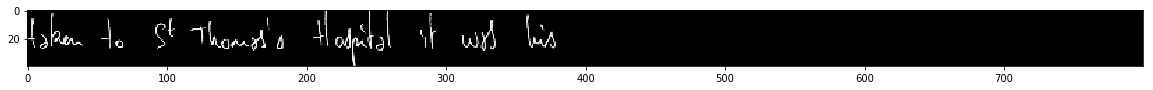

taken|to|St|Thomas's|Hospital|it|was|his


In [5]:
# Check random image
n = 1005
plt.figure(figsize = (20,2))
plt.imshow(images[n], cmap='gray')
plt.show()
print(''.join([char_map_inv[i] for i in labels[n]]))

### Processing 

In [6]:
len(char_map)

79

In [182]:
# # Only keep sentences with sequence length <= im_width//8
# indices = []
# for idx, val in enumerate(labels):
#     if len(val)<=(im_widths[idx]//8):
#         indices.append(idx)

In [184]:
# images = images[indices]
# labels = np.array(labels)
# labels = labels[indices]
# labels = list(labels)
# lab_lengths = lab_lengths[indices]
# im_widths = im_widths[indices]

In [7]:
# Uncomment and run if using Warp CTC loss - adds <BLANK> label
char_map['<BLANK>'] = len(char_map)
char_map_inv = {i:j for j,i in char_map.items()}

## CRNN 

In [8]:
class Config_CRNN():
    im_height = 40
    im_width = 800
    lab_length_cap = 100
    num_epochs = 350
    batch_size = 1
    
    # CNN
    conv1_patch_size = 3
    conv2_patch_size = 3
    conv3_patch_size = 3
    conv4_patch_size = 3
    conv1_depth = 12
    conv2_depth = 24
    conv3_depth = 48
    conv4_depth = 96
    
    # RNN
    rnn_num_hidden = 256
    num_layers = 4
    
    # Number of classes
    num_classes = 80
    
config_CRNN = Config_CRNN()

### Build the architecture using TensorFlow 

In [10]:
class CRNN(object):
    
    def __init__(self, config, savefile):
        
        self.config = config
        self.savefile = savefile
        tf.reset_default_graph()
        
    def read_and_decode(self):
        
        self.images = tf.placeholder(tf.float32,
                                          shape=(None, self.config.im_height, 
                                                 self.config.im_width, 1))
#         self.labels = tf.placeholder(tf.int32,
#                                           shape=(self.config.batch_size, self.config.lab_length_cap))
        self.labels_sparse = tf.sparse_placeholder(tf.int32)
        self.lengths = tf.placeholder(tf.int32,
                                          shape=(None))
        self.lab_lengths = tf.placeholder(tf.int32,
                                          shape=(None))
        
        self.val = tf.placeholder(tf.bool)
    
    def calc_ler(self, predicted, targets):
        return tf.edit_distance(tf.cast(predicted, tf.int32), targets, normalize=True)
    
    def lrelu(x, alpha):
        return tf.nn.relu(x) - alpha * tf.nn.relu(-x)
    
    def net(self):

        # Define CNN variables
        intitalizer = tf.contrib.layers.xavier_initializer_conv2d()
        self.layer1_weights = tf.Variable(intitalizer(
            [self.config.conv1_patch_size, self.config.conv1_patch_size, 1, self.config.conv1_depth]),
                                          name='conv1_W')
        self.layer1_biases = tf.Variable(tf.zeros([self.config.conv1_depth]), name='conv1_b')
        self.layer2_weights = tf.Variable(intitalizer(
            [self.config.conv2_patch_size, self.config.conv2_patch_size, 
             self.config.conv1_depth, self.config.conv2_depth]), name='conv2_W')
        self.layer2_biases = tf.Variable(tf.zeros([self.config.conv2_depth]), name='conv2_b')
        self.layer3_weights = tf.Variable(intitalizer(
            [self.config.conv3_patch_size, self.config.conv3_patch_size, 
             self.config.conv2_depth, self.config.conv3_depth]), name='conv3_W')
        self.layer3_biases = tf.Variable(tf.zeros([self.config.conv3_depth]), name='conv3_b')
        self.layer4_weights = tf.Variable(intitalizer(
            [self.config.conv4_patch_size, self.config.conv4_patch_size, 
             self.config.conv3_depth, self.config.conv4_depth]), name='conv4_W')
        self.layer4_biases = tf.Variable(tf.zeros([self.config.conv4_depth]), name='conv4_b')
        self.out_W = tf.Variable(tf.truncated_normal([2*self.config.rnn_num_hidden,
                                                 self.config.num_classes],
                                                stddev=0.1), name='out_W')
        self.out_b = tf.Variable(tf.constant(0., shape=[self.config.num_classes]), name='out_b')

        def model(images, seq_lengths, batch_size):
            # ==================1==================
            # CNN
            with tf.name_scope('CNN_1'):
                conv = tf.nn.conv2d(images, self.layer1_weights, [1, 1, 1, 1],
                                    padding='SAME')
                self.hidden_1 = lrelu(conv + self.layer1_biases)
                conv1_out = tf.nn.max_pool(self.hidden_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                      padding='SAME')

            # ==================2==================
            # CNN
            with tf.name_scope('CNN_2'):
                conv = tf.nn.conv2d(conv1_out, self.layer2_weights, [1, 1, 1, 1],
                                    padding='SAME')
                self.hidden_2 = lrelu(conv + self.layer2_biases)
                conv2_out = tf.nn.max_pool(self.hidden_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                      padding='SAME')

            # ==================3==================
            # CNN
            with tf.name_scope('CNN_3'):
                conv = tf.nn.conv2d(conv2_out, self.layer3_weights, [1, 1, 1, 1],
                                    padding='SAME')
                self.hidden_3 = lrelu(conv + self.layer3_biases)
                conv3_out = tf.nn.max_pool(self.hidden_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                      padding='SAME')

            # ==================4==================
            # CNN
            with tf.name_scope('CNN_4'):
                conv = tf.nn.conv2d(conv3_out, self.layer4_weights, [1, 1, 1, 1],
                                    padding='SAME')
                self.conv4_out = lrelu(conv + self.layer4_biases)

            cnn_out = tf.reduce_sum(self.conv4_out, axis=1)
            cnn_out = tf.transpose(cnn_out, [1, 0, 2])
            
            # Dropout
            if not self.val:
                cnn_out = tf.nn.dropout(cnn_out, keep_prob=0.8)
            
            if self.val:
                # Multi-Stacked RNN - reuse variables for validation set
                with tf.variable_scope('MultiRNN', reuse=True) as scope:
                    stacked_rnn = []
                    for i in range(self.config.num_layers):
                        stacked_rnn.append(tf.nn.rnn_cell.BasicLSTMCell(num_units=self.config.rnn_num_hidden,
                                                                   state_is_tuple=True))
                    with tf.variable_scope('forward') as fw_scope:
                        cell_fw = tf.nn.rnn_cell.MultiRNNCell(stacked_rnn,
                                                              state_is_tuple=True)
                    with tf.variable_scope('backward') as bw_scope:
                        cell_bw = tf.nn.rnn_cell.MultiRNNCell(stacked_rnn,
                                                              state_is_tuple=True)
                    self.output, self.state = tf.nn.bidirectional_dynamic_rnn(
                        cell_fw,
                        cell_bw,
                        inputs=cnn_out,
                        dtype=tf.float32,
                        sequence_length=seq_lengths,
                        time_major=True,
                        scope='MultiRNN'
                    )
            else:
                # Multi-Stacked RNN        
                with tf.variable_scope('MultiRNN') as scope:
                    stacked_rnn = []
                    for i in range(self.config.num_layers):
                        stacked_rnn.append(tf.nn.rnn_cell.DropoutWrapper(
                            tf.nn.rnn_cell.BasicLSTMCell(num_units=self.config.rnn_num_hidden,
                                                                   state_is_tuple=True),
                            state_keep_prob=1.0,
                            output_keep_prob=0.65,
                            variational_recurrent=True,
                            input_size=self.config.im_width//8,
                            dtype = tf.float32))
                    with tf.variable_scope('forward') as fw_scope:
                        cell_fw = tf.nn.rnn_cell.MultiRNNCell(stacked_rnn,
                                                              state_is_tuple=True)
                    with tf.variable_scope('backward') as bw_scope:
                        cell_bw = tf.nn.rnn_cell.MultiRNNCell(stacked_rnn,
                                                              state_is_tuple=True)
                    self.output, self.state = tf.nn.bidirectional_dynamic_rnn(
                        cell_fw,
                        cell_bw,
                        inputs=cnn_out,
                        dtype=tf.float32,
                        sequence_length=seq_lengths,
                        time_major=True,
                        scope='MultiRNN'
                    )
            
            # Fully Connected
            with tf.name_scope('Dense'):
                
                self.output = tf.concat(self.output, 2)
                
                # Reshaping to apply the same weights over the timesteps
                self.output = tf.reshape(self.output, [-1, 2*self.config.rnn_num_hidden])

                # Doing the affine projection
                self.logits = tf.matmul(self.output, self.out_W) + self.out_b

                
            # Reshaping back to the original shape
            logits = tf.reshape(self.logits, [batch_size, -1, self.config.num_classes])

            # Time major
            return tf.transpose(logits, (1, 0, 2))
        
        
        
        logits = model(self.images, self.lengths, self.config.batch_size)
        
        # For saving the model
        self.saver = tf.train.Saver()

        # Training computation
        self.loss = warpctc_tensorflow.ctc(logits, self.labels_sparse.values,
                                           self.lab_lengths, self.lengths, self.config.num_classes-1)
        self.cost = tf.reduce_mean(self.loss)
        
        # Optimizer.
        self.optimizer = tf.train.RMSPropOptimizer(0.00027).minimize(self.loss)
        
        # Training predictions and accuracy
        self.prediction = tf.nn.ctc_beam_search_decoder(logits, 
                                                    sequence_length=self.lengths,
                                                   merge_repeated=True)
        
        # Calculate ler
        self.ler = self.calc_ler(self.prediction[0][0], self.labels_sparse)
        
        
    def train(self):
                    
        num_steps = int((self.config.num_epochs*len(images))/self.config.batch_size)
                
        tf.reset_default_graph()

        self.read_and_decode()
        self.val = False
        self.net()

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        
        # TensorBoard Summaries
        train_cost_summary = tf.summary.scalar("training_cost", self.cost)
        train_ler_summary = tf.summary.scalar("training_ler", tf.reduce_mean(self.ler))

        # Convolution Summaries
        conv_l1_W = tf.summary.histogram("conv_l1_W", self.layer1_weights)
        conv_l1_b = tf.summary.histogram("conv_l1_b", self.layer1_biases)
        conv_l1_Act = tf.summary.histogram("conv_l1_Act", self.hidden_1)
        conv_l2_W = tf.summary.histogram("conv_l2_W", self.layer2_weights)
        conv_l2_b = tf.summary.histogram("conv_l2_b", self.layer2_biases)
        conv_l2_Act = tf.summary.histogram("conv_l2_Act", self.hidden_2)
        conv_l3_W = tf.summary.histogram("conv_l3_W", self.layer3_weights)
        conv_l3_b = tf.summary.histogram("conv_l3_b", self.layer3_biases)
        conv_l3_Act = tf.summary.histogram("conv_l3_Act", self.hidden_3)
        conv_l4_W = tf.summary.histogram("conv_l4_W", self.layer4_weights)
        conv_l4_b = tf.summary.histogram("conv_l4_b", self.layer4_biases)
        conv_l4_Act = tf.summary.histogram("conv_l4_Act", self.conv4_out)
        
        # RNN and Dense Summaries
        rnn_out = tf.summary.histogram("rnn_out", self.output)
        dense_W = tf.summary.histogram("dense_W", self.out_W)
        dense_b = tf.summary.histogram("dense_b", self.out_b)
        dense_logits = tf.summary.histogram("dense_logits", self.logits)
        
        with tf.Session() as sess:
                    
            summaries = tf.summary.merge_all()
            
            writer = tf.summary.FileWriter("./TensorBoard/lines", sess.graph)
#             run_metadata = tf.RunMetadata()
#             writer.add_run_metadata(run_metadata, 'compute')
            
            sess.run(init_op)
            print('Initialized')
            
            start = time.time()
            steps_time = start
            epoch_time = start
            
            epoch = 1
            epoch_train_cost = []
            epoch_train_ler = []
            
            for step in range(num_steps):

                offset = (step * self.config.batch_size) % (len(images) - self.config.batch_size+1)
                batch_images = images[offset:(offset + self.config.batch_size), :, :]
                batch_images = batch_images.reshape((self.config.batch_size, self.config.im_height,
                                             self.config.im_width, 1))
                batch_labels = labels[offset:(offset + self.config.batch_size)]
                batch_labels_sparse = sparse_tuple_from(batch_labels)
                batch_lengths = im_widths[offset:(offset + self.config.batch_size)]//8
                batch_lab_lengths = lab_lengths[offset:(offset + self.config.batch_size)]

                feed_dict = {self.images : batch_images, self.labels_sparse : batch_labels_sparse,
                             self.lengths : batch_lengths, self.lab_lengths : batch_lab_lengths}
                
                self.val = False
                _, c, ler_, predictions, summ = sess.run([self.optimizer, self.cost, self.ler,
                                                          self.prediction, summaries],
                                                         feed_dict=feed_dict)
                writer.add_summary(summ, step)
                
                epoch_train_cost.append(c)
                epoch_train_ler.append(ler_)
                
                if (step % 6000 == 0):
                    preds = np.zeros((predictions[0][0].dense_shape))
                    i =  0
                    for idx in predictions[0][0].indices:
                        preds[idx[0]][idx[1]] = predictions[0][0].values[i]
                        i+=1
                    print('Step %d:' % (step), round(time.time() - steps_time), 'seconds')
                    steps_time = time.time()
                    decoded_pred = [''.join([''.join([char_map_inv[j] for j in i]) for i in preds])]
                    print('Minibatch cost at step %d: %f' % (step, c))
                    print('Label =', ''.join([''.join([char_map_inv[j] for j in i]) for i in batch_labels]))
                    print('Prediction =', ''.join(decoded_pred))
                    print('Prediction with spell check =', 
                          '|'.join([correction(word) if word != '' else '' 
                                    for word in decoded_pred[0].split('|')]))

                if (step!=0 and (step+1) % int(len(images)/self.config.batch_size) == 0):

                    print('Epoch', epoch, 'Completed')
                    print('Time =', round(time.time() - epoch_time), 'seconds')
                    
                    # Getting validation prediction, loss and ler - passing one sasmple at a time
                    # as CTC gives very bad results if all are passed at once (maybe due to length)
                    epoch_val_cost = []
                    epoch_val_ler = []
                    for val_step in range(len(val_images)):
                        val_offset = (val_step * self.config.batch_size) % (len(val_images) - self.config.batch_size+1)
                        batch_val_images = val_images[val_offset:(val_offset + self.config.batch_size), :, :]
                        batch_val_images = batch_val_images.reshape((self.config.batch_size, 
                                                                     self.config.im_height,
                                                                     self.config.im_width, 1))
                        batch_val_labels = val_labels[val_offset:(val_offset + self.config.batch_size)]
                        batch_val_labels_sparse = sparse_tuple_from(batch_val_labels)
                        batch_val_lengths = val_im_widths[val_offset:(val_offset + self.config.batch_size)]//8
                        batch_val_lab_lengths = val_lab_lengths[val_offset:(val_offset + self.config.batch_size)]
                        
                        val_feed_dict = {self.images : batch_val_images, 
                                         self.labels_sparse : batch_val_labels_sparse,
                                         self.lengths : batch_val_lengths, 
                                         self.lab_lengths : batch_val_lab_lengths}
                        
                        self.val = True
                        val_cost, val_ler = sess.run([self.cost, self.ler], feed_dict=val_feed_dict)
                        
                        epoch_val_cost.append(val_cost)
                        epoch_val_ler.append(val_ler)
                        
                    # Writing values to TensoLogs and printing epoch results
                    epoch_val_cost, epoch_val_ler = np.mean(epoch_val_cost), np.mean(epoch_val_ler)
                    writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="val_cost", 
                                                                          simple_value=epoch_val_cost)]), epoch)
                    writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag="val_ler", 
                                                                          simple_value=epoch_val_ler)]), epoch)
                    
                    print('Cost: Training =', np.mean(epoch_train_cost), 
                          'Validation =', epoch_val_cost)
                    print('ler: Training =', np.mean(epoch_train_ler), 'Validation =', epoch_val_ler)
                    print('-------------------------------------------------------------------------------')
                    self.saver.save(sess, self.savefile)
                    epoch_train_cost = []
                    epoch_train_ler = []
                    epoch_time = time.time()
                    epoch+=1
            writer.close()
            print('Total runtime =', round(time.time() - start), 'seconds')
            
    def predict(self, X, X_width):
        with tf.Session() as sess:
            # restore the model
            self.saver.restore(sess, self.savefile)
            P = sess.run(self.prediction, feed_dict={self.images : X, self.lengths : X_width})
        return P

In [ ]:
model = CRNN(config=config_CRNN, savefile='./saved_model/lines/model_leaky_relu_v25Aug17')
model.train()

Initialized
Step 0: 0 seconds
Minibatch cost at step 0: 242.586594
Label = Ultratoryism|,|that|the|Commons|House|upon|a
Prediction = !z!z!z!.!.!.!u!u!o!o!ououou
Prediction with spell check = !z!z!z!.!.!.!u!u!o!o!ououou
Step 6000: 1922 seconds
Minibatch cost at step 6000: 79.728615
Label = rather|indignant|,|but|we|took|the
Prediction = ale|toed|tod|ae|thle|he.
Prediction with spell check = all|told|to|a|the|he
Epoch 1 Completed
Time = 1974 seconds
Cost: Training = 127.348 Validation = 109.021
ler: Training = 0.819128 Validation = 0.687795
-------------------------------------------------------------------------------
Step 12000: 1998 seconds
Minibatch cost at step 12000: 0.000000
Label = For|many|years|my|union|had|to|present|its|views
Prediction = the|any|pon|,|wanthath|pant|th|the
Prediction with spell check = the|any|pon|i|wanthath|part|the|the
Epoch 2 Completed
Time = 1958 seconds
Cost: Training = 100.527 Validation = 92.8315
ler: Training = 0.651759 Validation = 0.586123
---------

KeyboardInterrupt: 

In [19]:
def predict_function(image, saved_model = './saved_model/lines/model_CRNN_v22Aug17_0'):
    
    # Prepare image
    
    height_cap = 40
    width_cap = 800
    
    # Threshold images to remove background and invert colors
    im = cv2.bitwise_not(image)
    
    im = im.astype(np.float32)
    im = np.divide(im, 255.0)
    
    # Deskew image (remove slant)
    im = bounding_box(deskew(im, get_skew_angle(im)))
    
    # Resize - put a height cap and resize accordingly
    out_width = int((im.shape[1]/im.shape[0])*height_cap)

    if out_width < width_cap:
        im_widths = out_width

        im_without_pad = cv2.resize(im, (out_width, height_cap))
        im = np.zeros((height_cap, width_cap), dtype=np.float32)

        im_without_pad = im_without_pad.astype(np.float32)
        im[:,:out_width] = im_without_pad
    else:
        im_widths = width_cap
        im = cv2.resize(im, (width_cap, height_cap))
    
    plt.imshow(im, cmap='gray')
    plt.show()

    
    # Predict
    pred = CRNN(config=config_CRNN, savefile=saved_model)
    pred.val_images = val_images.reshape((len(val_images), pred.config.im_height,
                                         pred.config.im_width, 1))
    pred.val_labels = val_labels
    pred.val_labels_sparse = sparse_tuple_from(pred.val_labels)
    pred.val_lab_lengths = val_lab_lengths
    pred.val_lengths = val_im_widths//8
    pred.read_and_decode()
    pred.net()

    im_model = np.reshape(im, (pred.config.batch_size, pred.config.im_height, pred.config.im_width, 1))
    width_model = list(np.reshape(im_widths, (pred.config.batch_size))//8)

    return ''.join([char_map_inv[i] for i in pred.predict(im_model, width_model)[0][0][1]])

In [42]:
def predict_test(im, im_widths, saved_model = './saved_model/lines/model_CRNN_v20Aug17_0'):
    plt.figure(figsize=(20,10))
    plt.imshow(im, cmap='gray')
    plt.show()
    
    # Predict
    pred = CRNN(config=config_CRNN, savefile=saved_model)
    pred.val_images = val_images.reshape((len(val_images), pred.config.im_height,
                                         pred.config.im_width, 1))
    pred.val_labels = val_labels
    pred.val_labels_sparse = sparse_tuple_from(pred.val_labels)
    pred.val_lab_lengths = val_lab_lengths
    pred.val_lengths = val_im_widths//8
    pred.read_and_decode()
    pred.net()

    im_model = np.reshape(im, (pred.config.batch_size, pred.config.im_height, pred.config.im_width, 1))
    width_model = list(np.reshape(im_widths, (pred.config.batch_size))//8)

    return ''.join([char_map_inv[i] for i in pred.predict(im_model, width_model)[0][0][1]])

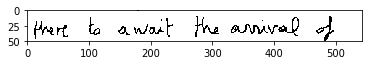

In [26]:
im =cv2.imread('processed-strokes.png', 0)
crop_im = im[150:200,:]
plt.imshow(crop_im, cmap='gray')
plt.show()

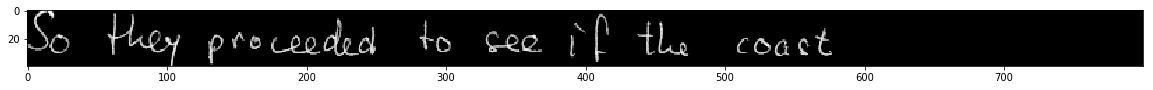

INFO:tensorflow:Restoring parameters from ./saved_model/lines/model_CRNN_v20Aug17_0
So|they|proveded|to|se|if|the|coast


In [53]:
print(predict_test(test_images[10], test_im_widths[10]))

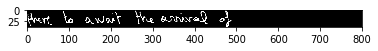

INFO:tensorflow:Restoring parameters from ./saved_model/lines/model_CRNN_v20Aug17_0
therl|to|a|wait|the|erviwval|of


In [54]:
print(predict_function(crop_im))